In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
import pycaret.classification as pc
from sklearn import metrics

%matplotlib inline
model_name = 'wine_model'

from pycaret.utils import version
version()

'3.2.0'

# Vinhos


## Leitura da Base 

In [2]:
df_wine = pandas.read_csv('../data/dataset_vinhos.csv',sep=';')
wine_target_col = 'target'
wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
print(df_wine.shape)
df_wine.head()

(5320, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,target_label,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,baixa qualidade,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,baixa qualidade,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,baixa qualidade,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,alta qualidade,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,baixa qualidade,red


## Configuração do PyCaret 

In [3]:
# pc.setup?

In [4]:
experiment = pc.setup(session_id=123,
                      data = df_wine, # Configurações de dados
                      train_size=0.6,
                      target = wine_target_col,
                      profile = False, # Analise interativa de variaveis
                      fold_strategy = 'stratifiedkfold', # Validação cruzada
                      fold = 10,
                      normalize = True,  # Normalização, transformação e remoção de variáveis
                      transformation = True, 
                      remove_multicollinearity = True,
                      multicollinearity_threshold = 0.95,
                      bin_numeric_features = None, # Binarizacao de variaveis
                      group_features = None, # Grupos de variáveis para combinar na engenharia de variaveis
                      categorical_features = ['type'],
                      ignore_features = ['target_label'],
                      log_experiment = False, # Logging dos experimentos e afins
                      experiment_name = 'wine-model',
                      )

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(5320, 14)"
4,Transformed data shape,"(5320, 13)"
5,Transformed train set shape,"(3192, 13)"
6,Transformed test set shape,"(2128, 13)"
7,Ignore features,1
8,Ordinal features,1
9,Numeric features,11


## Seleção de Modelos

In [5]:
# pc.models()
# pc.compare_models?

In [6]:
# pc.models()

In [7]:
# O PyCaret treina os modelos com hiperparametros defaults, sem ajuste fino.
model = pc.compare_models(n_select = 1, sort='Accuracy', include=['lr', 'dt', 'rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7754,0.8327,0.8494,0.8033,0.8257,0.5107,0.5124,0.1510
lr,Logistic Regression,0.7447,0.8130,0.8339,0.7760,0.8036,0.4400,0.4431,0.2880
dt,Decision Tree Classifier,0.6823,0.6627,0.7404,0.7499,0.7448,0.3239,0.3244,0.0400


In [8]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

## Ajuste de Hiperparâmetros 

In [9]:
# pc.tune_model?

In [10]:
tuned_model = pc.tune_model(model,
                            optimize = 'f1',
                            search_library = 'scikit-learn',
                            search_algorithm = 'random',
                            n_iter = 4)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7375,0.7784,0.8400,0.7636,0.8000,0.4207,0.4247
1,0.7125,0.7870,0.7950,0.7571,0.7756,0.3763,0.3771
2,0.7210,0.7505,0.8000,0.7656,0.7824,0.3943,0.3950
3,0.7367,0.8008,0.7800,0.7959,0.7879,0.4409,0.4410
4,0.7461,0.8158,0.8200,0.7847,0.8020,0.4487,0.4496
5,0.7398,0.7992,0.7350,0.8305,0.7798,0.4647,0.4699
6,0.7147,0.7697,0.8300,0.7444,0.7849,0.3653,0.3701
7,0.7398,0.8066,0.8050,0.7854,0.7951,0.4390,0.4392
8,0.7618,0.7992,0.7900,0.8229,0.8061,0.4975,0.4982


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Avaliação do Modelo 

In [11]:
# pc.evaluate_model?
# pc.plot_model?

In [12]:
pc.evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Interpretação dos Resultados 

In [13]:
# pc.interpret_model?

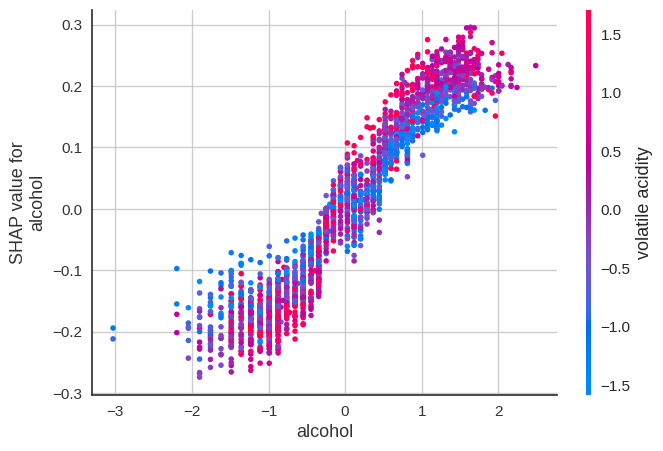

In [14]:
pc.interpret_model(tuned_model, plot='correlation', feature='alcohol')

## Calibração de Modelos 

In [15]:
# pc.calibrate_model?

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7621,0.8217,0.8425,0.7911,0.8160,0.4806,0.4825
1,0.7653,0.8419,0.8400,0.7962,0.8175,0.4892,0.4906
2,0.7900,0.8543,0.8675,0.8107,0.8382,0.5400,0.5425
3,0.7508,0.8287,0.8550,0.7720,0.8114,0.4470,0.4521
4,0.7743,0.8245,0.8546,0.7986,0.8257,0.5067,0.5091
Mean,0.7685,0.8342,0.8519,0.7937,0.8217,0.4927,0.4954
Std,0.0131,0.0122,0.0099,0.0126,0.0094,0.0306,0.0299


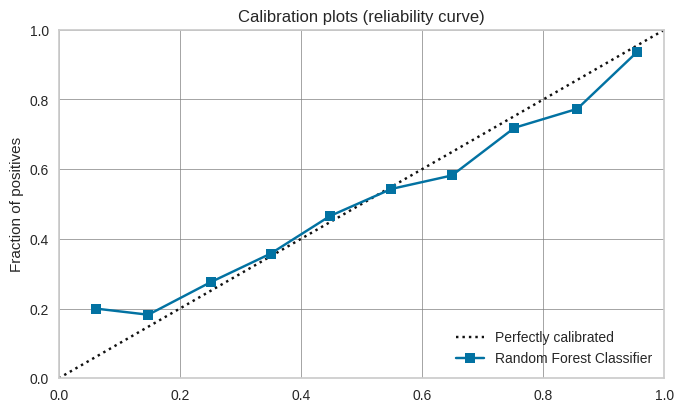

In [16]:
calibrated_model = pc.calibrate_model(tuned_model, method='sigmoid', calibrate_fold=5, fold=5)
pc.plot_model(calibrated_model, plot='calibration')

## Optimização da Operação 

In [17]:
# pc.optimize_threshold(calibrated_model, optimize = 'Precision');

## Avaliação do Teste 

In [18]:
# pc.predict_model?

In [19]:
pred_holdout = pc.predict_model(calibrated_model) # holdout set (test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7660,0.8301,0.8492,0.7922,0.8197,0.4875,0.4899


In [20]:
pred_holdout.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,target,prediction_label,prediction_score
5319,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,white,1,1,0.8955
1556,7.2,0.23,0.38,14.3,0.058,55.0,194.0,0.99790,3.09,0.44,9.0,white,1,1,0.7193
4739,7.0,0.22,0.30,1.4,0.040,14.0,63.0,0.98985,3.20,0.33,12.0,white,1,1,0.8745
1435,6.8,0.25,0.31,13.3,0.050,69.0,202.0,0.99720,3.22,0.48,9.7,white,1,1,0.5055
1976,6.2,0.25,0.48,10.0,0.044,78.0,240.0,0.99655,3.25,0.47,9.5,white,1,0,0.5911


## Finalização do Modelo para Produção

In [21]:
# pc.finalize_model?

In [22]:
final_model = pc.finalize_model(calibrated_model)
pred_final = pc.predict_model(final_model) # holdout set (test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9958,0.9999,0.9977,0.9955,0.9966,0.9910,0.9910


## Exportação do Experimento 

In [23]:
# pc.load_config?
# pc.save_config?
# pc.load_model?
# pc.save_model?

In [24]:
pc.save_model(calibrated_model, model_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['fixed acidity',
                                              'volatile acidity', 'citric acid',
                                              'residual sugar', 'chlorides',
                                              'free sulfur dioxide',
                                              'total sulfur dioxide', 'density',
                                              'pH', 'sulphates', 'alcohol'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_feature...
                                                                               criterion='gini',
  